In [18]:
import numpy as np
import scipy
import random
import pandas as pd
import pickle
import seaborn.objects as so
import hashlib
import matplotlib.pyplot as plt


import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats   

In [68]:
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [1146]:
%%scalene --profile-all --cli

def tester(x):
    c = 0
    for i in range(x):
        for j in range(10000):
            c += 1

tester(100)

                                      [1146]: % of time = 100.00% (50.321ms) out of 50.321ms.                                      
       ╷       ╷       ╷       ╷       ╷                                                                                           
       │Time   │–––––– │–––––– │–––––– │                                                                                           
  Line │Python │native │system │GPU    │[1146]                                                                                     
╺━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸
     1 │       │       │       │       │%%scalene --profile-all --cli                                                              
     2 │       │       │       │       │                                                                                           
     3 │       │       │       │       │def tester(x):                      

In [490]:
class MetricManager:
    def __init__(self, metrics):
        self.metrics = metrics

        self.runs = pd.DataFrame(metrics).drop(["expert metrics", "verma", "hemmer"], axis=1)

        self.metrics_dfs = {
            "verma": {},
            "hemmer": {}
        }

    def create_dataframe_one_metric(self, run, method, seed, fold, step):
        """
        Returns a complete DataFrame for a specified L2D algorithm
        """
        if method == "verma":
            return self.create_dataframe_verma(run, seed, fold, step)
        if method == "hemmer":
            return self.create_dataframe_hemmer(run, seed, fold, step)

    def create_dataframe_verma(self, run, seed, fold, step):
        """
        Creates a dataframe which contains all metrics for verma for a given run, seed, fold and step

        Result is a DataFrame with every metric for the (run, seed, fold) combination
        """
        df = pd.DataFrame(self.metrics[run]["verma"][seed][fold][step]).drop(["acc_experts", "cov_experts"], axis=0).T
        df["coverage"] = df["coverage"].apply(lambda x: getCountOfCoverage(x))
        df.rename(columns={'coverage':'n_images'}, inplace=True)
        return df

    def create_dataframe_hemmer(self, run, seed, fold, step):
        """
        Creates a dataframe which contains all metrics for hemmer for a given run, seed, fold and step

        Result is a DataFrame with every metric for the (run, seed, fold) combination
        """
        df = pd.DataFrame(self.metrics[run]["hemmer"][seed][fold]["train"]).T
        n_images = getCountOfCoverage(self.metrics[run]["verma"][seed][fold]["train"][0]["coverage"])
        experts = [column[7:] for column in df.columns if "Expert" in column]
        df["Classifier Coverage"] = n_images * df["Classifier Coverage"]
        for expert in experts:
            df[f"{expert} Accuracy"] = [row["expert_accuracy"] for row in df[f"Expert_{expert}"]]
            df[f"{expert} Subset Accuracy"] = [row["expert_task_subset_accuracy"] for row in df[f"Expert_{expert}"]]
            df[f"{expert} Coverage"] = [n_images * row["expert_coverage"] for row in df[f"Expert_{expert}"]]
            df = df.drop([f"Expert_{expert}"], axis=1)
        return df

    def create_l2d_dataframe(self, metric, method, step):
        """
        Creates a multiindex dataframe which contains all metrics for a L2D method and given step

        Result is a multiindex df (run, seed, fold)
        """
        dict_run = {}
        for run in range(len(metrics)):
            dict_seed = {}
            for seed, val1 in self.metrics[run][method].items():
                dict_fold = {}
                for fold, element in self.metrics[run][method][seed].items():
                    dict_fold[f"Fold_{fold}"] = self.create_dataframe_one_metric(run, method, seed, fold, step)
                df_seed = pd.concat(dict_fold)
                dict_seed[f"Seed_{seed}"] = df_seed
            df_run = pd.concat(dict_seed)
            dict_run[f"Run_{run}"] = df_run
        df_test = pd.concat(dict_run)
        return df_test

    def get_l2d_dataframe(self, method, step):
        """
        Returns the needed df

        Stores created dfs to speed up the process
        """
        if step not in self.metrics_dfs[method]:
            self.metrics_dfs[method][step] = self.create_l2d_dataframe(self.metrics, method, step)
        return self.metrics_dfs[method][step]

    def create_metric_dataframe(self, df, metric_name, method):
        """
        Creates the df for a L2D method and a specified aggregation method

        Current implemented are max and var for the aggregation of a (run, seed, fold) combination
        """
        dff = df[[metric_name]]
        index = dff.index
        index_runs = index.get_level_values(0).drop_duplicates()
        index_seeds = index.get_level_values(1).drop_duplicates()
        index_folds = index.get_level_values(2).drop_duplicates()

        values = {}
        for run in index_runs:
            run_list = []
            for seed in index_seeds:
                for fold in index_folds:
                    if method == "max":
                        run_list.append(dff.loc[(run, seed, fold)].max()[0])
                    if method == "var":
                        run_list.append(dff.loc[(run, seed, fold)].var()[0])
            values[run] = run_list
        return pd.DataFrame(values)

    def get_metric_dataframe(self, method, step, metric_name, apply_method):
        """
        Returns a dataframe for one metric

        Columns are runs, rows are the max/var of the L2D systems metric for every fold
        """
        df = self.get_l2d_dataframe(method, step) #Get metrics for every run, seed, fold
        return self.create_metric_dataframe(df, metric_name, apply_method)

    def get_metrics_dataframe_cut(self, method, step, metric_name, apply_method, unwanted_tuple=None):
        """
        Cuts the name and add the posibility to remove unwanted parameter-value pairs
        """
        df = cut_column_name(self.get_metric_dataframe(method, step, metric_name, apply_method))
        columns = df.columns
        if unwanted_tuple is not None: # Get only indieces of runs without unwanted parameter-value pairs
            columns = [str(el) for el in list(remove_unwanted_runs(df_runs, unwanted_tuple).index)]
        return df.loc[:,columns] #Return metric for every run with applied method to aggregate seeds and folds
        

    def print_metrics(self, df):
        """
        Prints the columns of a drataframe to get all available metrics
        """
        print(df.columns)

    def get_ttest(self, value1, value2, equal_var=True):
        """
        Does a t-test for two given lists
        """
        res = ttest_ind(value1, value2, equal_var=equal_var)
        return res

def check_all_ttest(df, p=0.05, equal_var=False, plot=False):
    """
    Checks all columns of the dataframe of statistical significance
    """
    matrix = {}
    for i in df.columns:
        row = {}
        for j in df.columns:
            if i == j:
                row[j] = 1
            else:
                res = get_ttest(df.loc[:,[i]], df.loc[:,[j]], equal_var=equal_var)
                row[j] = res.pvalue[0]
        matrix[i] = row

    if plot:
        df = pd.DataFrame(matrix)
        plot_ttests(df)
    return matrix

def get_ttest(value1, value2, equal_var=True):
    res = ttest_ind(value1, value2, equal_var=equal_var, nan_policy="omit")
    #print(res)
    return res

def plot_ttests(df):
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(25, 11))
    sns.heatmap(df, annot=True, linewidths=.5, ax=ax)

def getCountOfCoverage(text):
    """
    Returns the number of images from the verma-metric coverage text
    """
    marker = None
    for j in range(len(text)):
        if text[-j] == "f":
            marker = j -1
    return int(text[-marker:])

def cut_column_name(df):
    columns = [column[4:] for column in df.columns]
    df.columns = columns
    return df

In [473]:
import glob

with open("Metrics_Folder/Metrics_43.pickle", 'rb') as handle:
    metrics = pickle.load(handle)

metricManager = MetricManager(metrics)

In [493]:
#import lzma
#
#with lzma.open("Current_Metric.xz", "wb") as handle:
#    pickle.dump(metrics, handle)

In [975]:
#with open(f'Metrics_Folder/Metrics_{18}.pickle', 'wb') as handle:
#    pickle.dump(metrics[:18], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [474]:
df_runs = pd.DataFrame(metrics).drop(["expert metrics", "verma", "hemmer"], axis=1)
metricManager.runs

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",0,4,8,32,"(0, 0)",5,PERFECT,perfect,target,False
1,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,False
2,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,True
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
5,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,False
6,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,True
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
9,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,False


In [466]:
def get_rungroup_name(df_runs, runs_g, var_columns, reverse=False):

    const_columns = [column for column in df_runs.columns if column not in var_columns]
    if reverse:
        const_columns = var_columns

    group_dict = []
    for run_group in runs_g:
        group_dict.append(dict(df_runs.loc[run_group[0], const_columns]))

    keys = []
    for i in range(len(group_dict) - 1):
        temp_keys = [k for k in group_dict[i] if group_dict[i][k] != group_dict[i + 1][k]]
        for key in temp_keys:
            if key not in keys:
                keys.append(key)
    keys.reverse()

    run_names = []
    for run_group in runs_g:
        run_names.append(create_run_name_from_columns(df_runs.loc[run_group[0]], keys))

    return run_names, keys

def create_run_name_from_columns(run, columns):
    name = ""
    #columns.reverse()
    for column in columns:
        name = name + f"{column}_{run.loc[column]}_"
    return name[:-1]

In [467]:
def remove_unwanted_runs(df, unwanted_tuples):
    dff = df
    for pair in unwanted_tuples:
        dff = dff[dff[pair[0]] != pair[1]]
    return dff

def get_runs_grouped(df, var_columns, reverse=False):
    """
    Groups the runs by their parameters
    All parameters except the passed ones are equal

    Returns a list whichs elements are lists of equal runs
    """
    const_columns = [column for column in df.columns if column not in var_columns]
    if reverse:
        const_columns = var_columns
    pairs = []
    referenc_row = None
    index_list = list(df.index)
    for index in df.index:
        if index in [el for sublist in pairs for el in sublist]:
            continue
        index_list.remove(index)
        referenc_row = df.loc[index, const_columns].to_dict()
        pair = [index]
        for index_j in index_list:
            current_row = df.loc[index_j, const_columns].to_dict()
            if referenc_row == current_row:
                pair.append(index_j)
        for el in pair:
            if el in index_list:
                index_list.remove(el)
        pairs.append(pair)
    return pairs

def get_runs_grouped_metric(df_runs, df_metrics, var_columns, reverse=False, unwanted_tuples=None):
    """
    Returns a DataFrame with grouped runs
    var_columns are the coulmns which aren't fix, all other are
    Reverse makes all columns variable except var_columns
    """

    if unwanted_tuples is not None:
        df_runs = remove_unwanted_runs(df_runs, unwanted_tuples)
    
    g_runs = get_runs_grouped(df_runs, var_columns, reverse)
    df = None
    first_indices = []
    for run_group in g_runs:
        first_indices.append(run_group[0])
        values = []
        for run in run_group:
            values = values + df_metrics[str(run)].tolist()
        dff = pd.DataFrame(values, columns=[str(run_group)])
        if df is None:
            df = dff
        else:
            df = pd.concat([df, dff], axis=1)


    df.columns, keys = get_rungroup_name(df_runs, g_runs, var_columns, reverse)

    df.columns = df_runs.loc[first_indices, keys].index
    
    return df, df_runs.loc[first_indices, keys]



In [468]:
def get_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None):
    if unwanted_tuples is not None:
        df_runs = remove_unwanted_runs(df_runs, unwanted_tuples)
    
    g_runs = get_runs_grouped(df_runs, var_columns, False)

    df = None
    first_indices = []
    dfs = []
    for run_group in g_runs:
        first_indices.append(run_group[0])
        values = {}
        run_dfs = []
        for run in run_group:
            temp_dict = {
                "value": df_metrics[str(run)],
            }
            for column in var_columns:
                temp_dict[column] = [df_runs.loc[run, column] for i in range(len(temp_dict["value"]))]
            df = pd.DataFrame(temp_dict)
            #print(df)
            run_dfs.append(df)
        dff = pd.concat(run_dfs)
        #dff["group"] = [g_runs.index(run_group) for i in range(len(dff))]
        dff["group"] = [run_group[0] for i in range(len(dff))]
        dfs.append(dff)

    _, keys = get_rungroup_name(df_runs, g_runs, var_columns, False)
    
    return pd.concat(dfs), df_runs.loc[first_indices, keys]

def plot_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None):
    df, runs_df = get_runs_hue_metric(df_runs.iloc[:], df_test, var_columns, [("expert_predict", "right")])

    print(runs_df)

    sns.boxplot(df, y="value", x="group", hue=df[var_columns].apply(tuple, axis=1))
    pass



                  mod  setting  labeled  rounds  init_size
0             perfect  PERFECT       32       8          0
3          confidence       AL       16       2          8
7        disagreement       AL       16       2          8
11  disagreement_diff       AL       16       2          8
13                ssl      SSL       16       2          8
15         confidence   SSL_AL       16       2          8
17       disagreement   SSL_AL       16       2          8
19  disagreement_diff   SSL_AL       16       2          8
23             normal   NORMAL       16       2          8


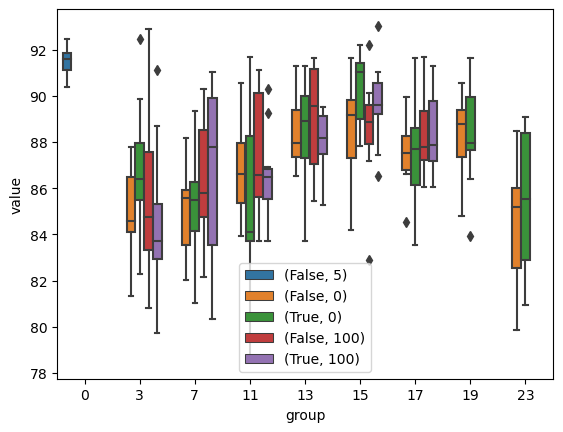

In [488]:
var_columns = ["sample_equal", "overlap"]

df_test = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "system_accuracy", "max"))
plot_runs_hue_metric(df_runs.iloc[:], df_test, var_columns, [("expert_predict", "right")])

,mod,setting,labeled,rounds,init_size
0,perfect,PERFECT,32,8,0
3,confidence,AL,16,2,8
7,disagreement,AL,16,2,8
11,disagreement_diff,AL,16,2,8
13,ssl,SSL,16,2,8
15,confidence,SSL_AL,16,2,8
17,disagreement,SSL_AL,16,2,8
19,disagreement_diff,SSL_AL,16,2,8
23,normal,NORMAL,16,2,8


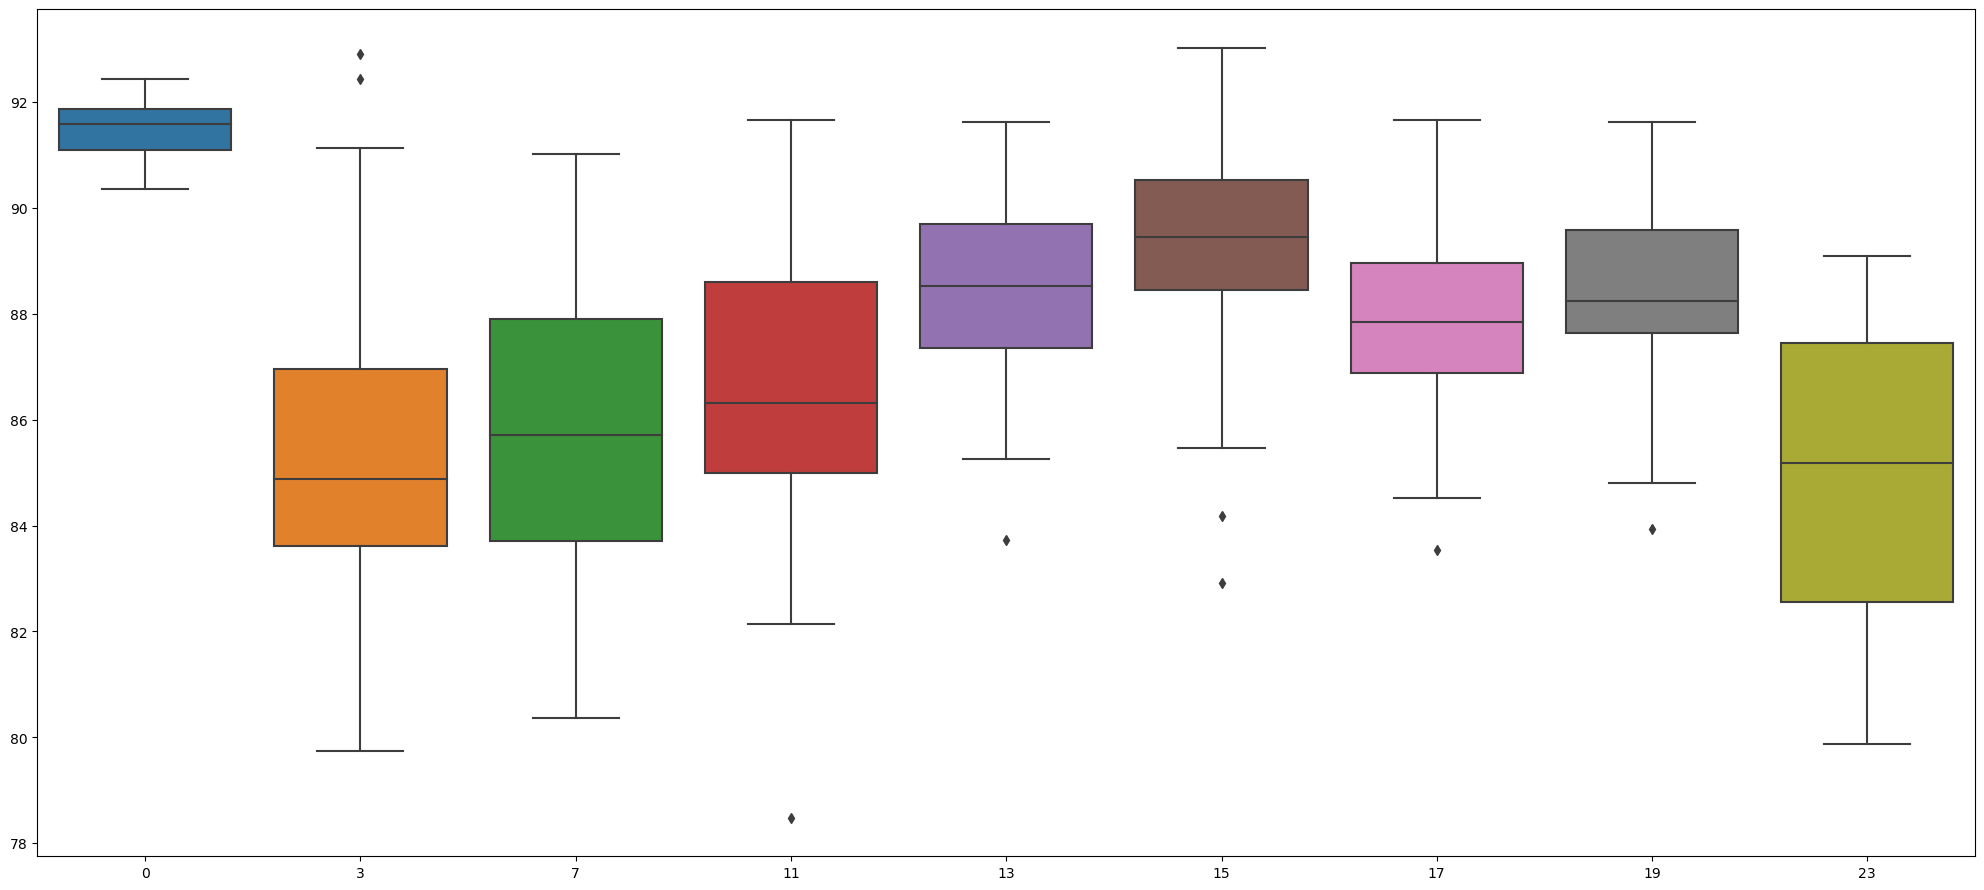

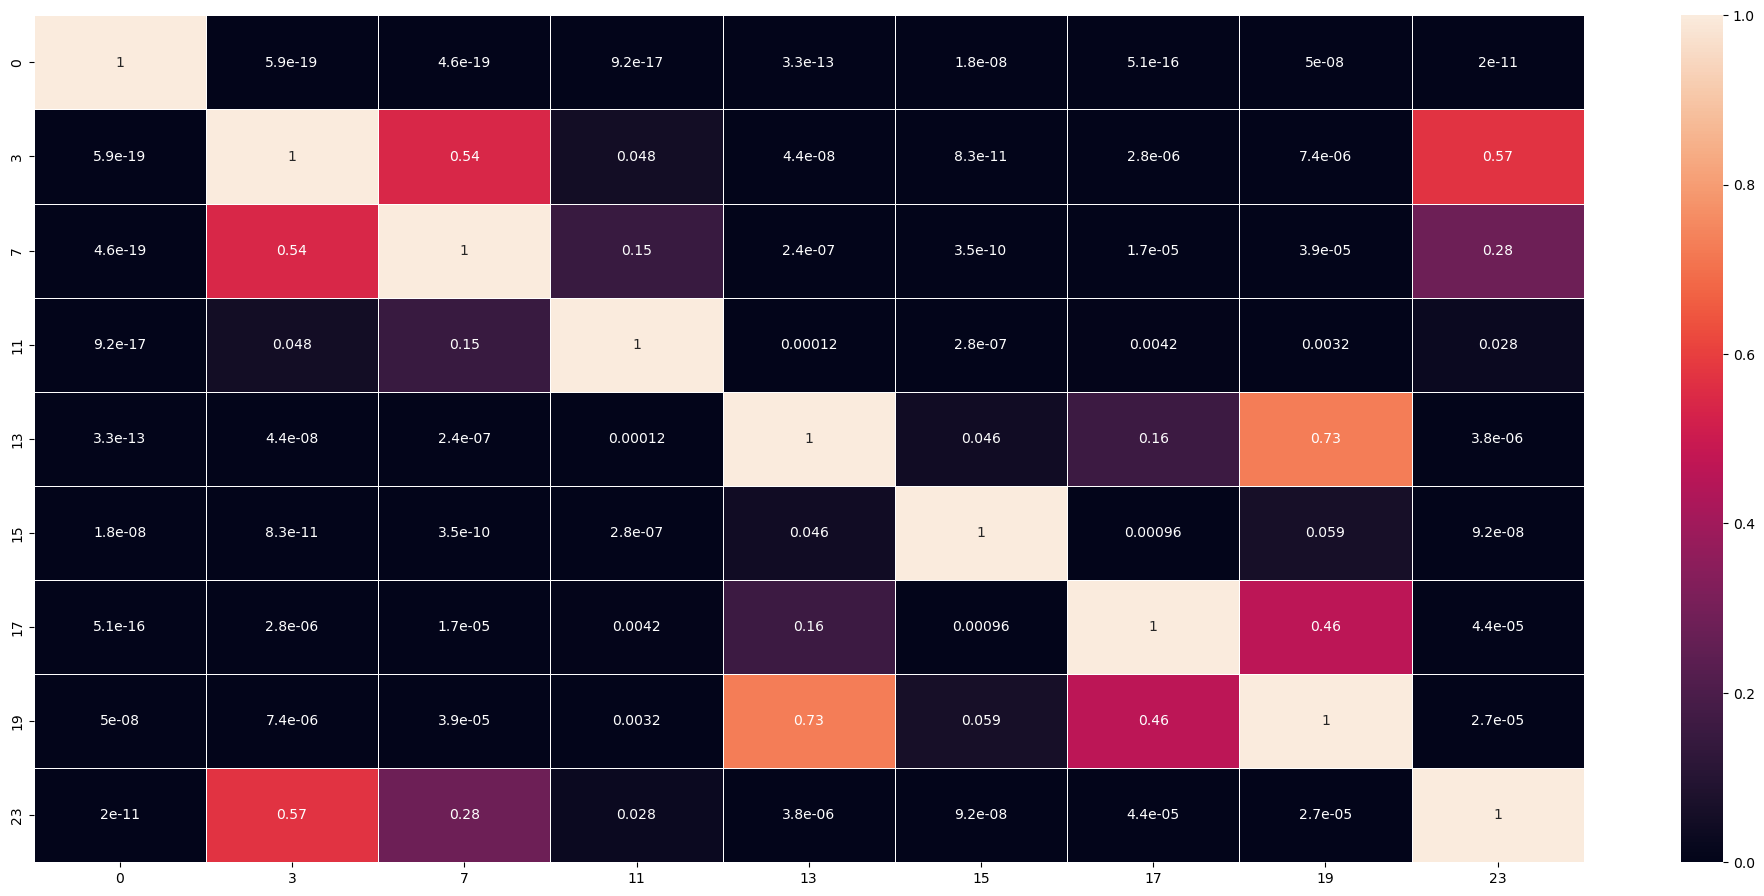

In [492]:
var_columns = ["sample_equal", "expert_predict", "overlap"]

df_test = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "system_accuracy", "max"))
df, selected_runs = get_runs_grouped_metric(df_runs.iloc[:], df_test, var_columns, False, [("expert_predict", "right")])
f, ax = plt.subplots(figsize=(25, 11))
sns.boxplot(df)

check_all_ttest(df, plot=True)

selected_runs.head(15)

,mod,setting,labeled,rounds,init_size
0,perfect,PERFECT,32,8,0
3,confidence,AL,16,2,8
7,disagreement,AL,16,2,8
11,disagreement_diff,AL,16,2,8
13,ssl,SSL,16,2,8
15,confidence,SSL_AL,16,2,8
17,disagreement,SSL_AL,16,2,8
19,disagreement_diff,SSL_AL,16,2,8
23,normal,NORMAL,16,2,8


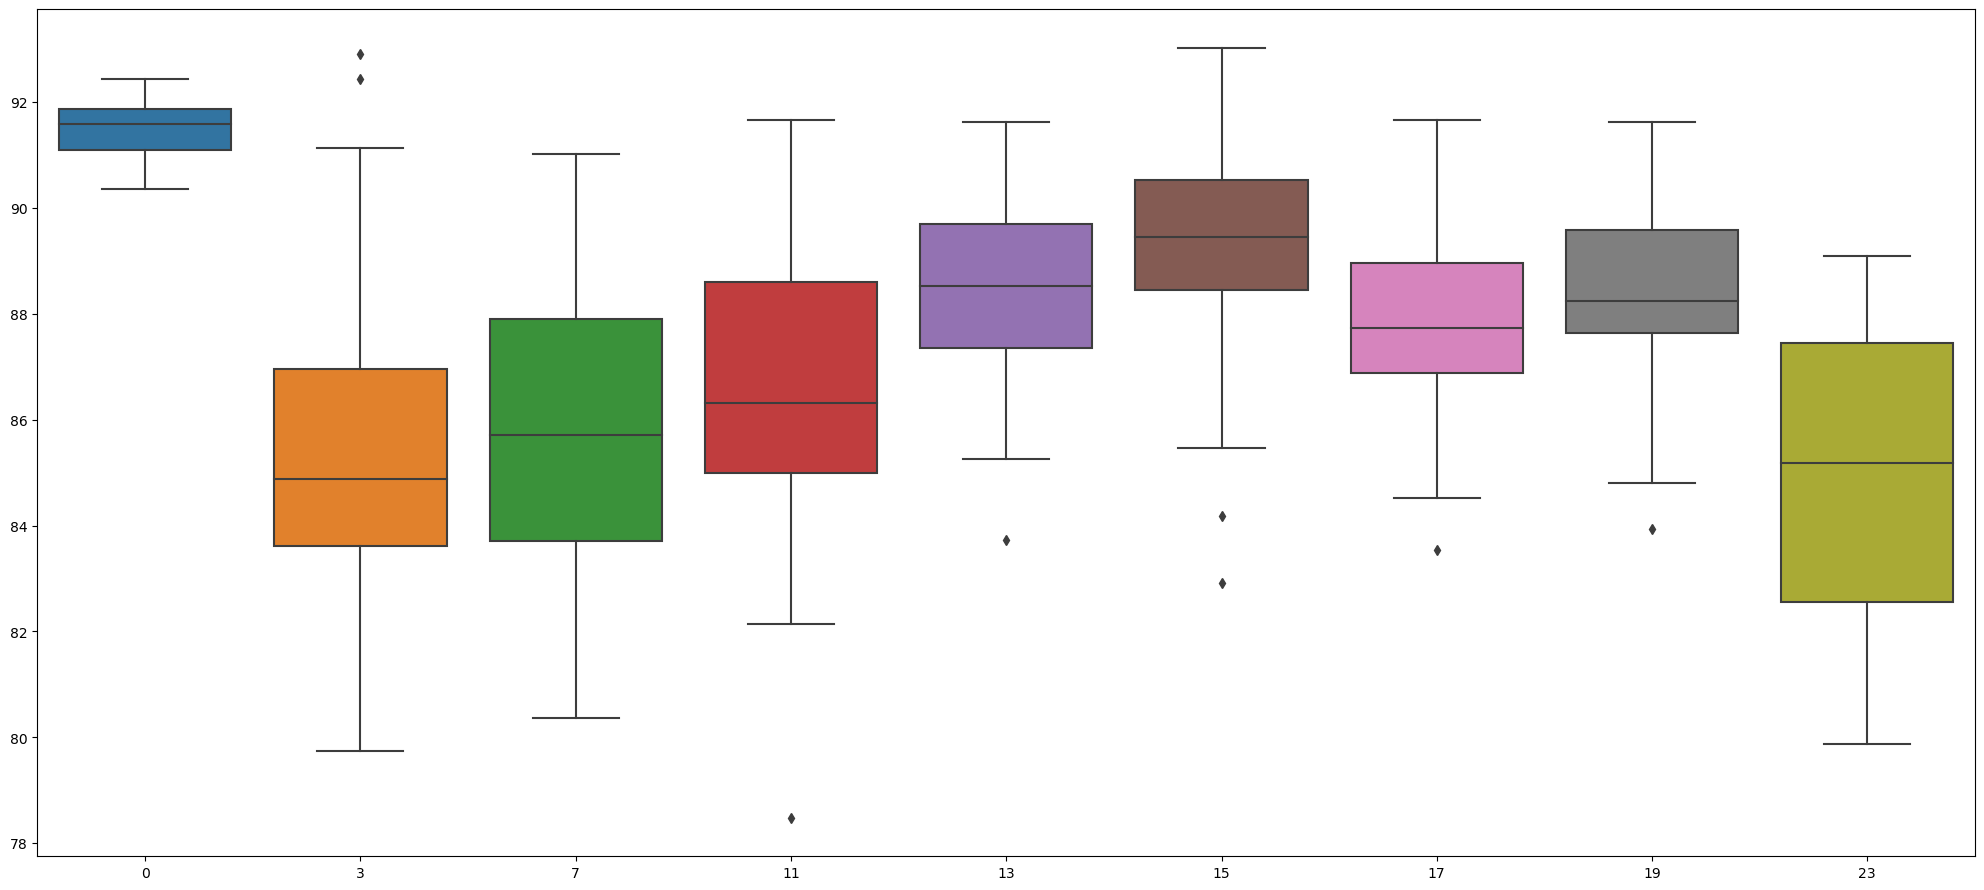

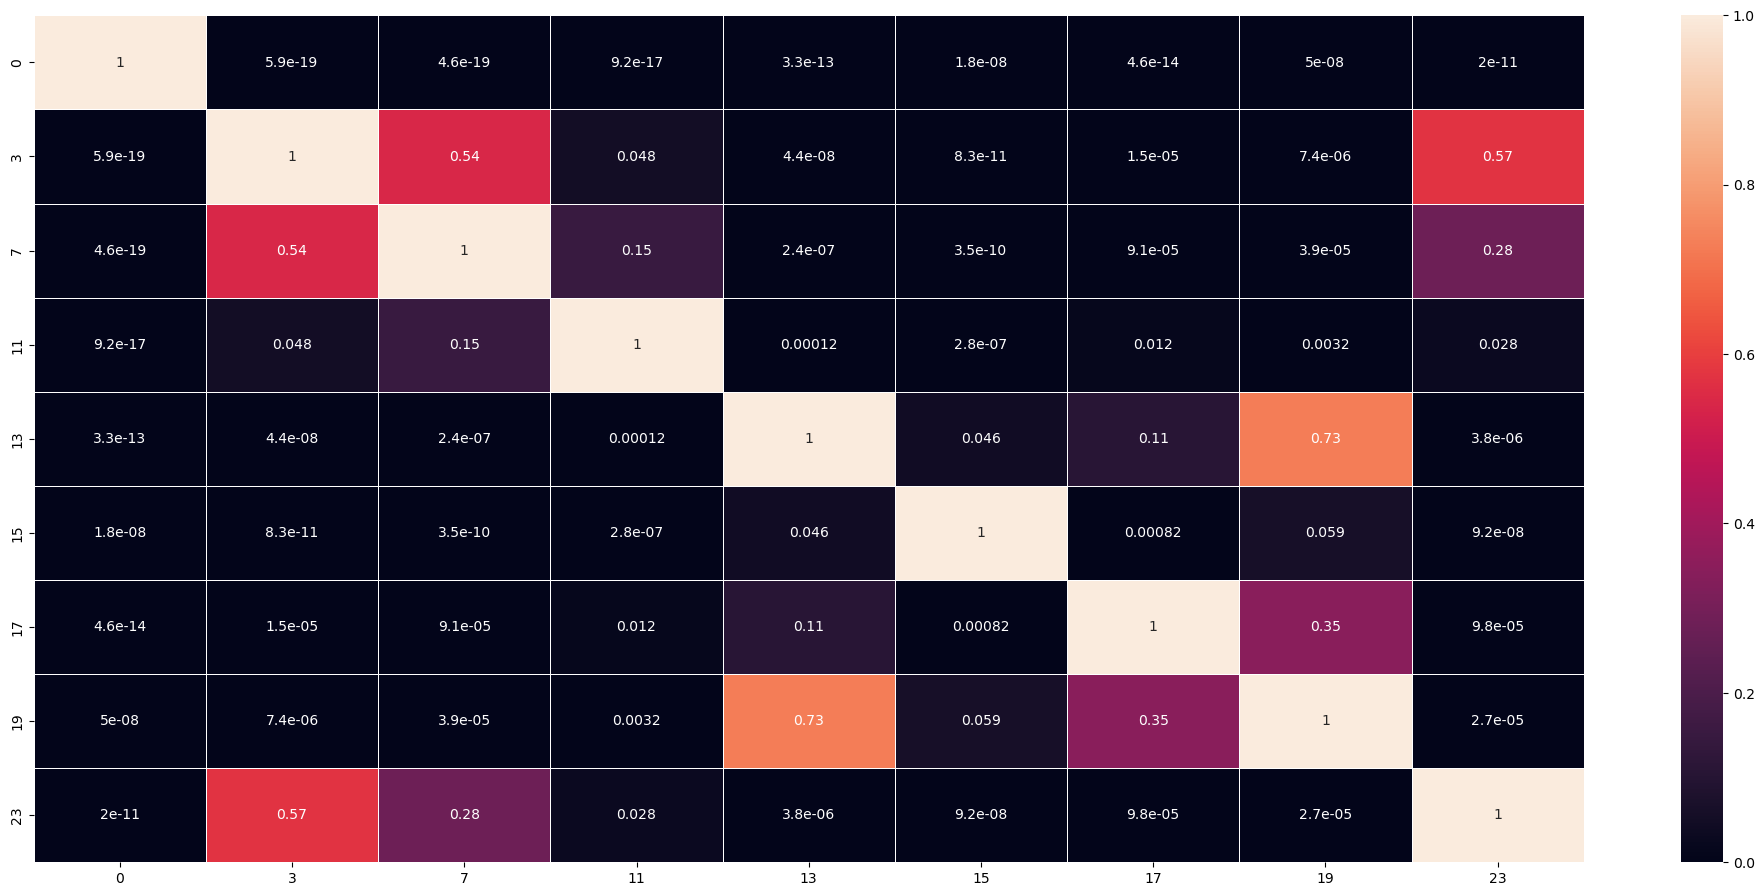

In [363]:
var_columns = ["sample_equal", "expert_predict", "overlap"]

df_test = metricManager.get_metrics_dataframe_cut("verma", "val", "system_accuracy", "max")
df, selected_runs = get_runs_grouped_metric(df_runs.iloc[:], df_test, var_columns, False, [("expert_predict", "right")])
f, ax = plt.subplots(figsize=(25, 11))
sns.boxplot(df)

df_ttests = pd.DataFrame(check_all_ttest(df))
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 11))
sns.heatmap(df_ttests, annot=True, linewidths=.5, ax=ax)

selected_runs.head(15)

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",0,4,8,32,"(0, 0)",5,PERFECT,perfect,target,False
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
11,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,target,False
12,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,target,True
13,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL,ssl,target,False
14,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL,ssl,target,True
15,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL_AL,confidence,target,False


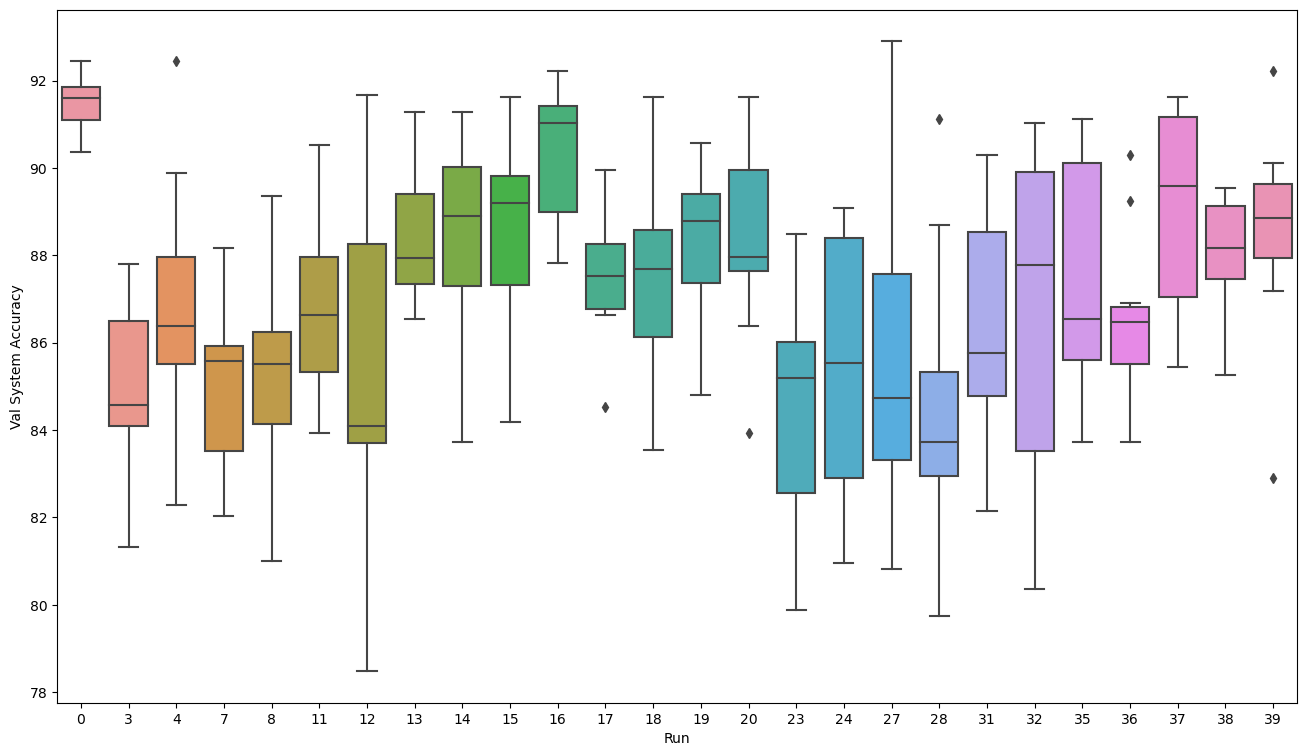

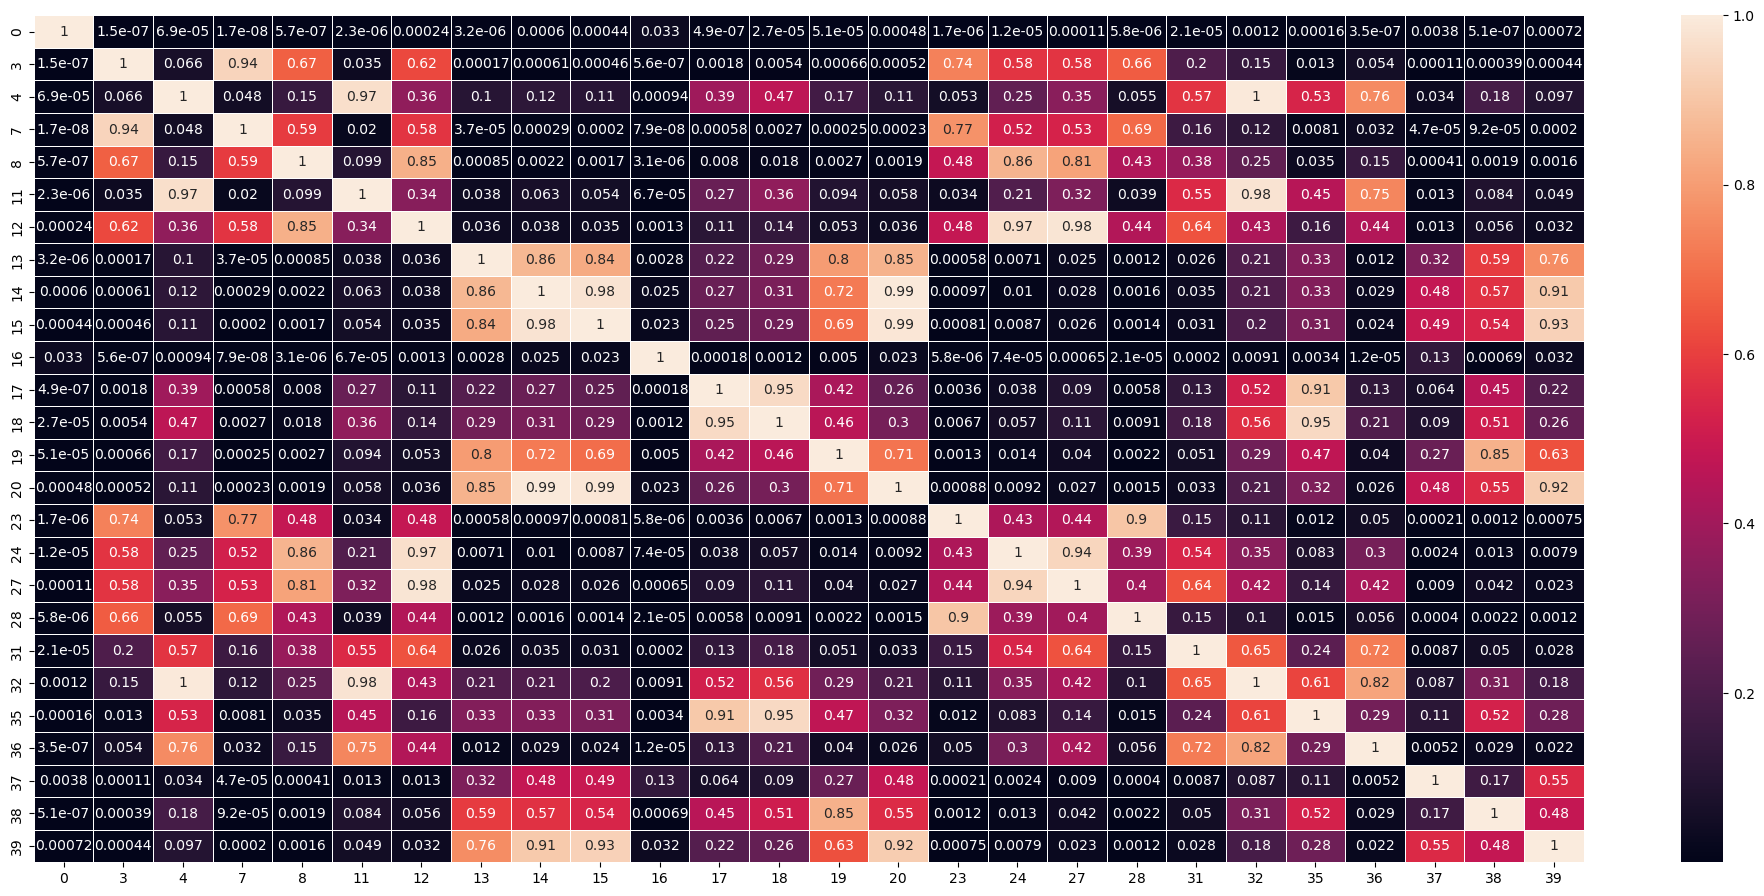

In [325]:
exclude = [("expert_predict", "right")]
#exclude = None

#df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "system_accuracy", "max"))#.T.iloc[[1, 2, 3, 4, 25, 26, 27, 28]].T
df_accuracy = metricManager.get_metrics_dataframe_cut("verma", "val", "system_accuracy", "max", exclude)
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Val System Accuracy')
sns.boxplot(df_accuracy)

df_ttests = pd.DataFrame(check_all_ttest(df_accuracy))
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 11))
sns.heatmap(df_ttests, annot=True, linewidths=.5, ax=ax)

df_runs.loc[[int(el) for el in df_accuracy.columns]]

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",0,4,8,32,"(0, 0)",5,PERFECT,perfect,target,False
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
11,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,target,False
12,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,target,True
13,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL,ssl,target,False
14,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL,ssl,target,True
15,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,SSL_AL,confidence,target,False


<Axes: >

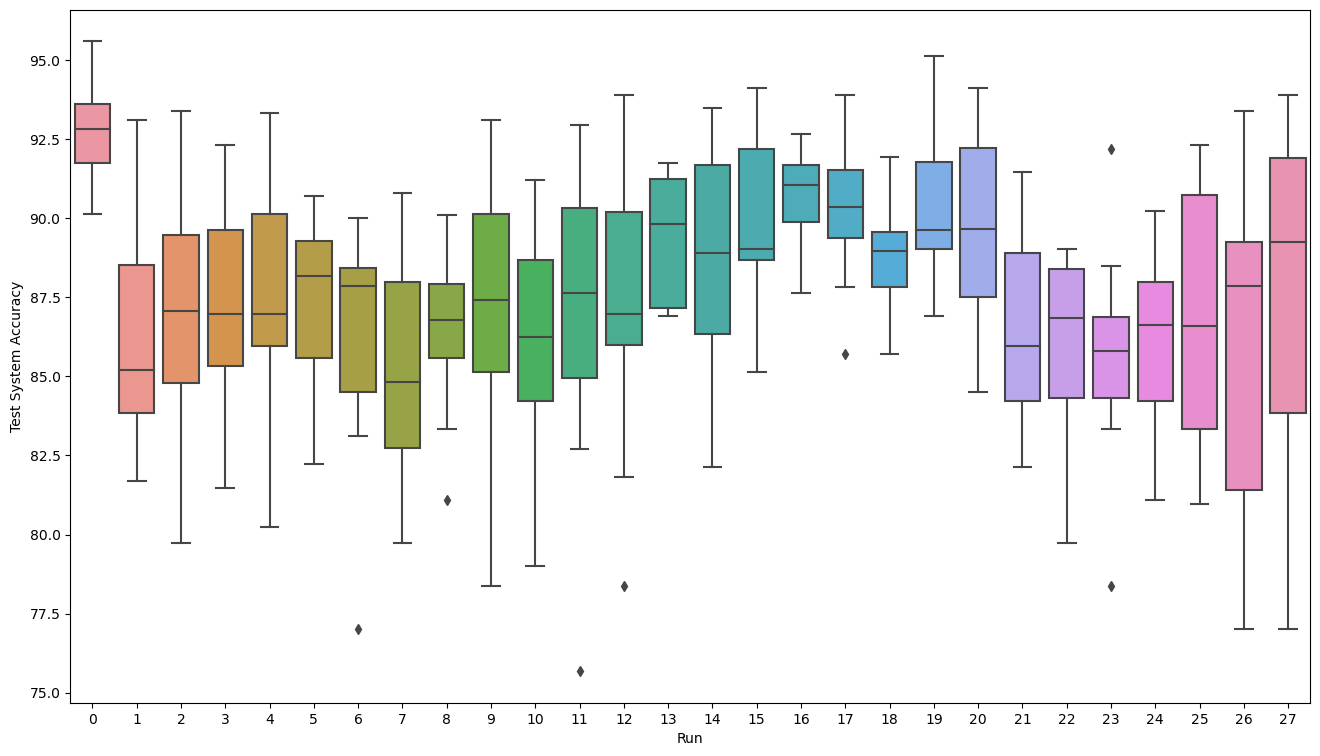

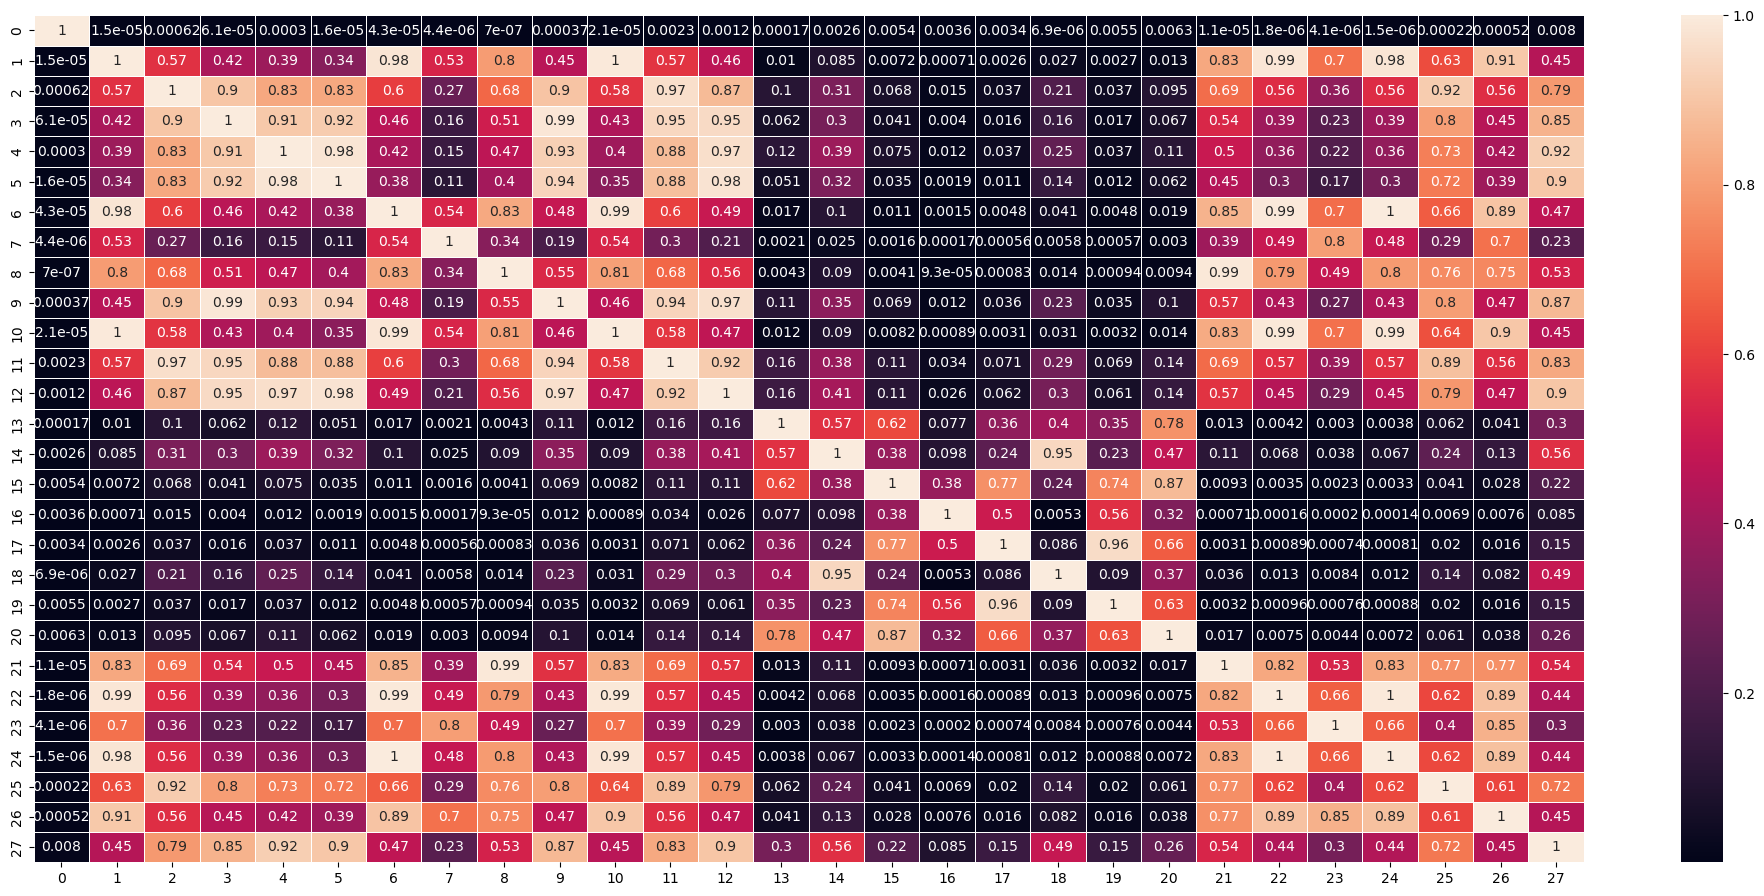

In [41]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "test", "system_accuracy", "max"))
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Test System Accuracy')
sns.boxplot(df_accuracy)

df_ttests = pd.DataFrame(check_all_ttest(df_accuracy))
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 11))
sns.heatmap(df_ttests, annot=True, linewidths=.5, ax=ax)

<Axes: xlabel='Run', ylabel='Val Classifier Coverage'>

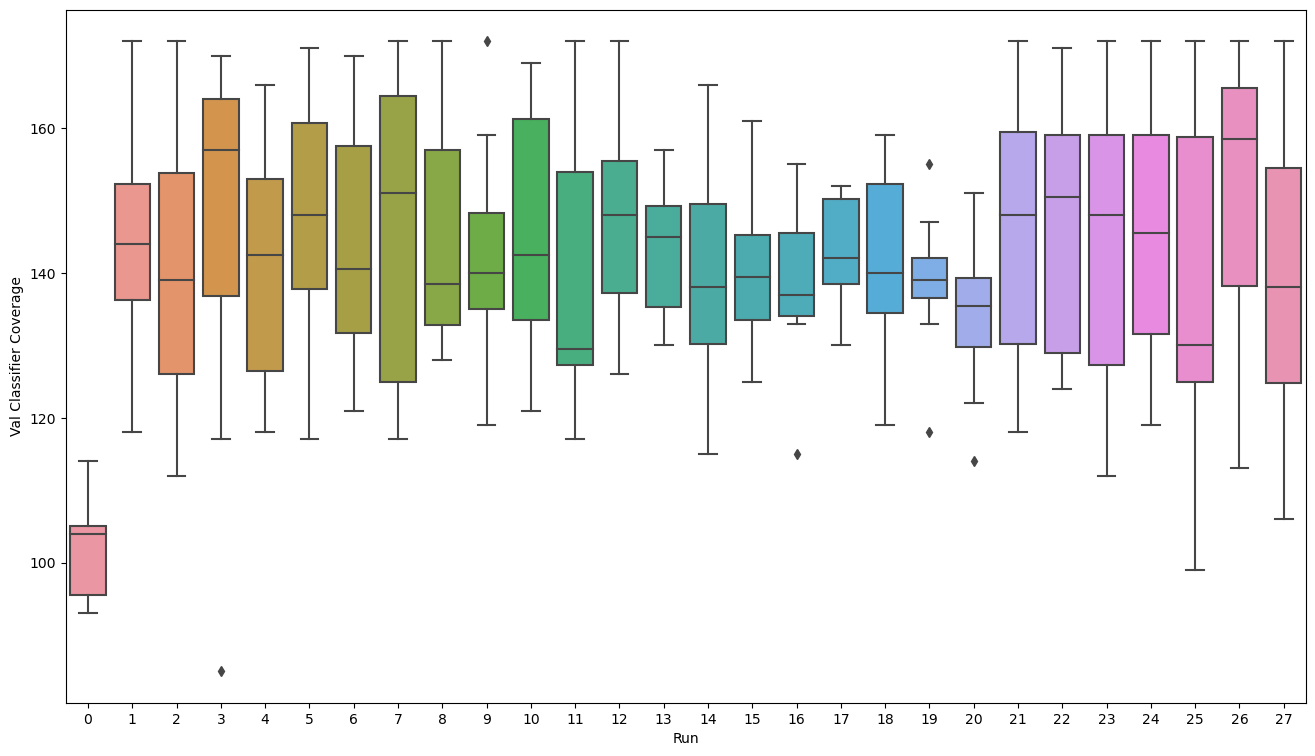

In [43]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "cov_classifier", "max"))
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Val Classifier Coverage')
sns.boxplot(df_accuracy)

<Axes: xlabel='Run', ylabel='Test Classifier Coverage'>

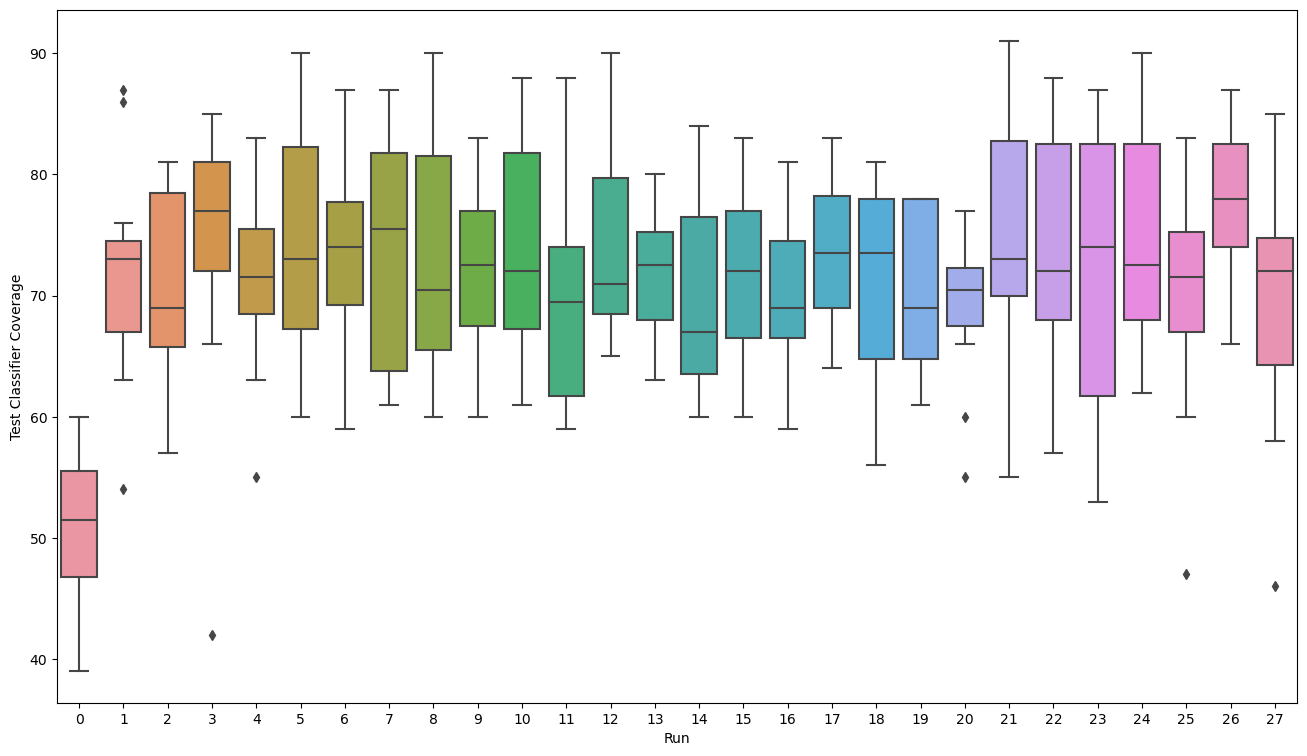

In [44]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "test", "cov_classifier", "max"))
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Test Classifier Coverage')
sns.boxplot(df_accuracy)

<Axes: xlabel='Run', ylabel='Val Classifier Accuracy'>

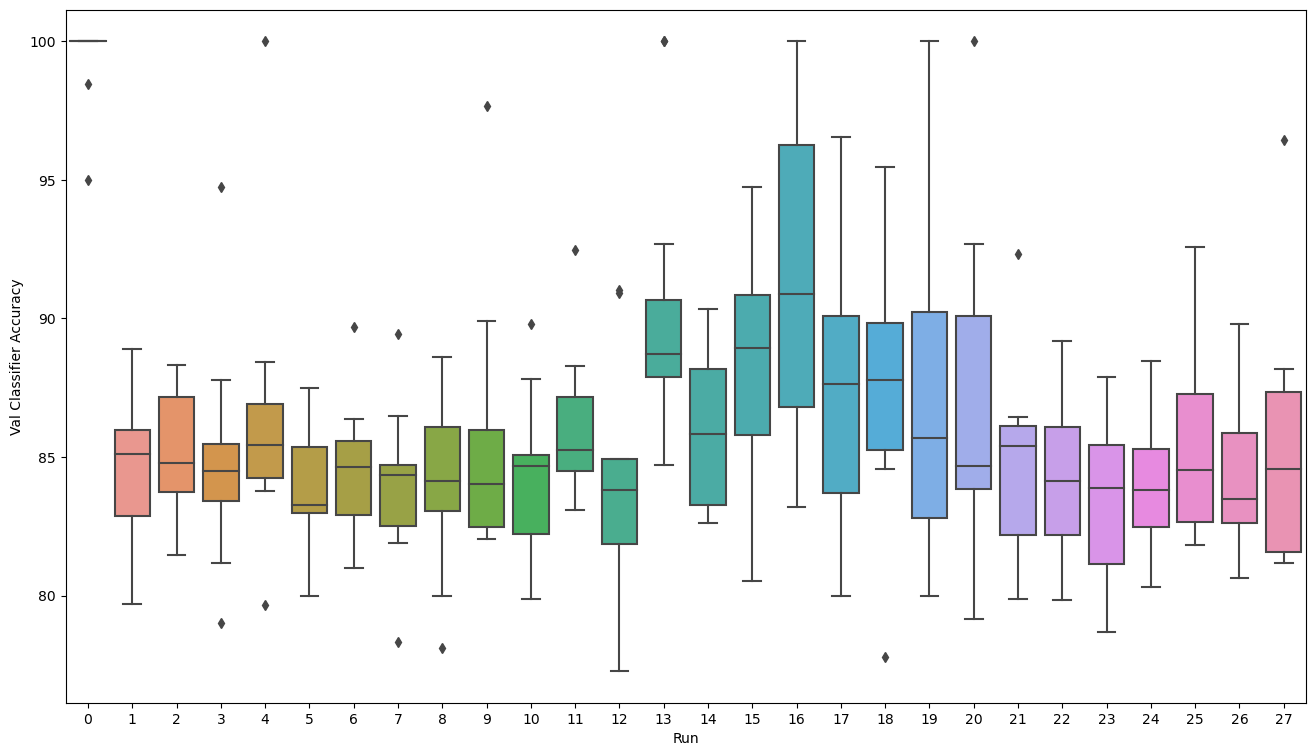

In [45]:
df_accuracy = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "classifier_accuracy", "max"))
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Val Classifier Accuracy')
sns.boxplot(df_accuracy)

In [674]:
import math

expert_metrics = []
for run in values:
    temp1 = {
        4323195249: {},
        4295232296: {},
    }
    for column in run:
        temp1[4323195249][column] = [el[0] if isinstance(el, list) else None for el in run[column]]
        temp1[4295232296][column] = [el[0] if isinstance(el, list) else None for el in run[column]]
    expert_metrics.append(temp1)

In [700]:
pd.DataFrame(pd.DataFrame(expert_metrics)[4323195249])

,4323195249
0,"{'Seed_1_Fold_0': [47, 29, 23, 22, 21, 18, 23,..."
1,"{'Seed_1_Fold_0': [44, 13, 4, 15, 19, 34, 36, ..."
2,"{'Seed_1_Fold_0': [77, 64, 62, 46, 32, 44, 43,..."
3,"{'Seed_1_Fold_0': [78, 73, 75, 50, 33, 37, 41,..."
4,"{'Seed_1_Fold_0': [72, 17, 9, 8, 16, 26, 22, 1..."
5,"{'Seed_1_Fold_0': [83, 41, 16, 12, 17, 17, 24,..."
6,"{'Seed_1_Fold_0': [74, 20, 8, 7, 21, 16, 18, 2..."
7,"{'Seed_1_Fold_0': [124, 107, 88, 52, 44, 35, 4..."


In [673]:
df1 = pd.DataFrame(temp1[4323195249])

In [671]:
df11 = df1.fillna(df1.mean())
pd.DataFrame(df11.mean())

,0
Seed_1_Fold_0,24.115385
Seed_1_Fold_1,39.846154
Seed_1_Fold_2,37.923077
Seed_1_Fold_3,6.038462
Seed_2_Fold_0,21.500000
Seed_2_Fold_1,10.230769
Seed_2_Fold_2,23.576923
Seed_2_Fold_3,45.269231
Seed_3_Fold_0,32.269231
Seed_3_Fold_1,32.222222


In [648]:
pd.DataFrame(temp1[4323195249])

,Seed_1_Fold_0,Seed_1_Fold_1,Seed_1_Fold_2,Seed_1_Fold_3,Seed_2_Fold_0,Seed_2_Fold_1,Seed_2_Fold_2,Seed_2_Fold_3,Seed_3_Fold_0,Seed_3_Fold_1,Seed_3_Fold_2,Seed_3_Fold_3
0,47.0,98.0,41.0,6.0,16.0,21.0,14.0,57.0,24.0,60,94.0,75
1,29.0,52.0,23.0,0.0,4.0,0.0,8.0,79.0,23.0,33,92.0,113
2,23.0,20.0,28.0,0.0,6.0,1.0,5.0,66.0,33.0,15,59.0,76
3,22.0,19.0,36.0,0.0,10.0,1.0,13.0,37.0,39.0,17,51.0,53
4,21.0,30.0,27.0,1.0,12.0,9.0,19.0,40.0,28.0,12,42.0,30
5,18.0,29.0,44.0,2.0,25.0,12.0,22.0,39.0,30.0,17,40.0,25
6,23.0,43.0,33.0,7.0,22.0,5.0,20.0,35.0,17.0,31,29.0,47
7,15.0,33.0,32.0,7.0,21.0,11.0,26.0,39.0,26.0,28,60.0,35
8,22.0,36.0,27.0,8.0,17.0,9.0,35.0,31.0,29.0,32,45.0,56
9,15.0,40.0,34.0,7.0,19.0,10.0,29.0,41.0,37.0,32,40.0,56


In [607]:
values[0]

,Seed_1_Fold_0,Seed_1_Fold_1,Seed_1_Fold_2,Seed_1_Fold_3,Seed_2_Fold_0,Seed_2_Fold_1,Seed_2_Fold_2,Seed_2_Fold_3,Seed_3_Fold_0,Seed_3_Fold_1,Seed_3_Fold_2,Seed_3_Fold_3
0,"[47, 33]","[98, 4]","[41, 18]","[6, 49]","[16, 10]","[21, 23]","[14, 3]","[57, 1]","[24, 3]","[60, 65]","[94, 1]","[75, 16]"
1,"[29, 0]","[52, 0]","[23, 1]","[0, 14]","[4, 6]","[0, 0]","[8, 0]","[79, 0]","[23, 0]","[33, 65]","[92, 0]","[113, 3]"
2,"[23, 1]","[20, 0]","[28, 1]","[0, 11]","[6, 11]","[1, 0]","[5, 0]","[66, 0]","[33, 0]","[15, 76]","[59, 0]","[76, 7]"
3,"[22, 6]","[19, 1]","[36, 2]","[0, 12]","[10, 14]","[1, 0]","[13, 0]","[37, 0]","[39, 0]","[17, 65]","[51, 0]","[53, 17]"
4,"[21, 8]","[30, 1]","[27, 9]","[1, 24]","[12, 14]","[9, 0]","[19, 0]","[40, 0]","[28, 1]","[12, 57]","[42, 0]","[30, 17]"
5,"[18, 7]","[29, 6]","[44, 7]","[2, 19]","[25, 13]","[12, 3]","[22, 0]","[39, 0]","[30, 8]","[17, 37]","[40, 2]","[25, 12]"
6,"[23, 16]","[43, 11]","[33, 12]","[7, 22]","[22, 20]","[5, 4]","[20, 2]","[35, 0]","[17, 8]","[31, 45]","[29, 2]","[47, 26]"
7,"[15, 11]","[33, 10]","[32, 18]","[7, 30]","[21, 19]","[11, 1]","[26, 2]","[39, 0]","[26, 3]","[28, 44]","[60, 4]","[35, 27]"
8,"[22, 9]","[36, 2]","[27, 18]","[8, 21]","[17, 16]","[9, 1]","[35, 0]","[31, 0]","[29, 8]","[32, 39]","[45, 6]","[56, 16]"
9,"[15, 10]","[40, 9]","[34, 23]","[7, 24]","[19, 18]","[10, 3]","[29, 0]","[41, 0]","[37, 9]","[32, 48]","[40, 7]","[56, 16]"


In [ ]:
dict_run = {}
for run in range(len(metrics)):
    dict_seed = {}
    for seed, val1 in metrics[run]["verma"].items():
        dict_fold = {}
        for fold, element in metrics[run]["verma"][seed].items():
            dict_fold[f"Fold_{fold}"] = create_dataframe_one_metric(metrics, run, "verma", seed, fold, "val")
        df_seed = pd.concat(dict_fold)
        dict_seed[f"Seed_{seed}"] = df_seed
    df_run = pd.concat(dict_seed)
    dict_run[f"Run_{run}"] = df_run
pd.concat(dict_run)

## Experts

In [476]:
import matplotlib.pyplot as plt

def get_expert_values(step, metric_name):

    mett = []
    for element in metrics:
        met = {}
        for seed, value1 in element["expert metrics"].items():
            for fold, value2 in value1.items():
                for expert, value3 in value2.items():
                    if expert not in met:
                        met[expert] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"]["End"] = value3[step]["End"][metric_name]
                    if "Start" in value3[step]:
                        met[expert][f"Seed_{seed}_Fold_{fold}"]["Start"] = value3[step]["Start"][metric_name]
                    else:
                        pass
        mett.append(met)
    return mett

def get_single_values(met, run, expert_id, step):
    values = []
    for key, value in met[run][expert_id].items():
        values.append(value[step])
    return values

def plot_expert_values(met):
    df1 = pd.DataFrame(met[4323195249])
    df2 = pd.DataFrame(met[4295232296])

    fd1 = df1.T.reset_index()
    fd1["expert"] = 4323195249
    fd2 = df2.T.reset_index()
    fd2["expert"] = 4295232296
    df3 = pd.concat([fd1, fd2])
    df3 = df3.melt(id_vars=["index", "expert"])

    plt.figure()
    sns.boxplot(df3, x="expert", y="value",
            hue="variable",)

,labeler_ids,init_size,labels_per_round,rounds,labeled,cost,overlap,setting,mod,expert_predict,sample_equal
0,"[4323195249, 4295232296]",0,4,8,32,"(0, 0)",5,PERFECT,perfect,target,False
1,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,False
2,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,right,True
3,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,False
4,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,confidence,target,True
5,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,False
6,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,right,True
7,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,False
8,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement,target,True
9,"[4323195249, 4295232296]",8,4,2,16,"(0, 0)",0,AL,disagreement_diff,right,False


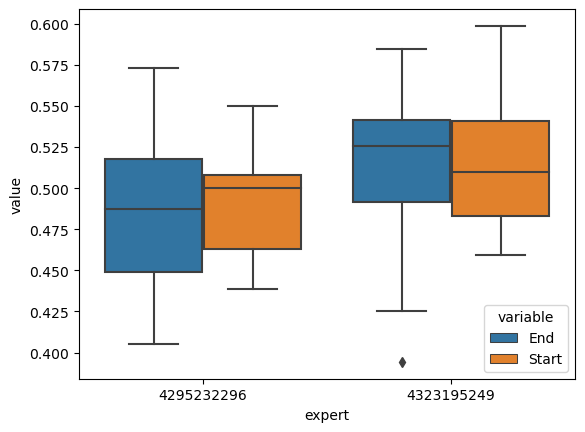

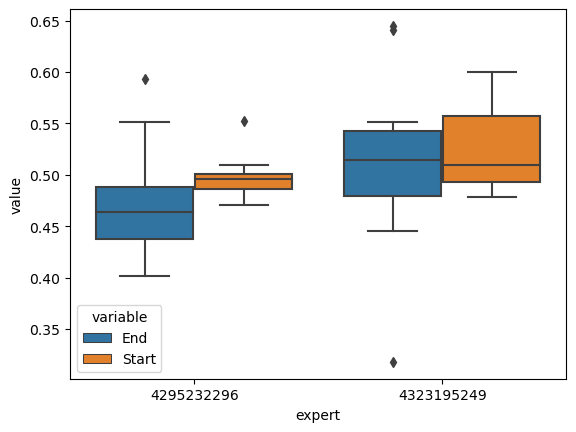

In [478]:
met = get_expert_values("Val", "accurancy_balanced")

plot_expert_values(met[2])
plot_expert_values(met[1])
df_runs

In [480]:
met = get_expert_values("Val", "accurancy_balanced")

In [483]:
def create_expert_metrics(met):
    metrics = {}
    for expert_id in met[0]:
        metrics[expert_id] = []
        for run in met:
            start_metrics = {}
            end_metrics = {}
            for seed_fold, value in run[expert_id].items():
                if "Start" in value:
                    start_metrics[seed_fold] = value["Start"]
                end_metrics[seed_fold] = value["End"]
            if len(start_metrics) == 0:
                start_metrics = end_metrics
            metrics[expert_id].append({
                "Start": start_metrics,
                "End": end_metrics
            })
    return metrics

def get_expert_df(metrics, expert_id, start=False):
    if start:
        df1 = pd.DataFrame([row["Start"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='start')
    df2 = pd.DataFrame([row["End"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='end')

    if start:
        df_final = df1
        df_final["end"] = df2["end"]
    else:
        df_final = df2
    df_final = df_final.melt(id_vars=["index", "seed_fold"], var_name="step")

    return df_final

def plot_expert_runs_al(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id, start=True)
    plt.figure()
    sns.boxplot(df, x="index", y="value", hue="step")

def plot_expert_runs_end(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id)
    plt.figure()
    sns.boxplot(df, x="index", y="value")

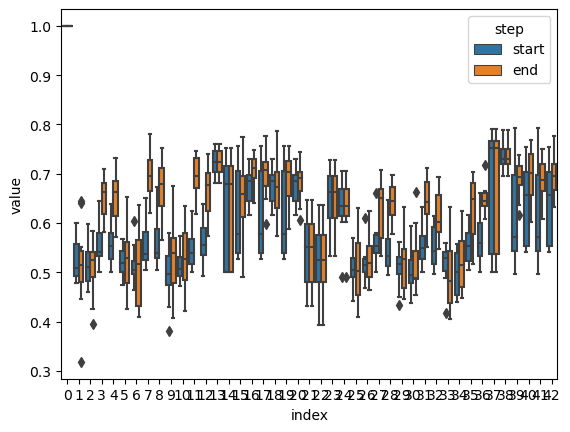

In [484]:
plot_expert_runs_al(metrics, 4323195249, "Val", "accurancy_balanced")

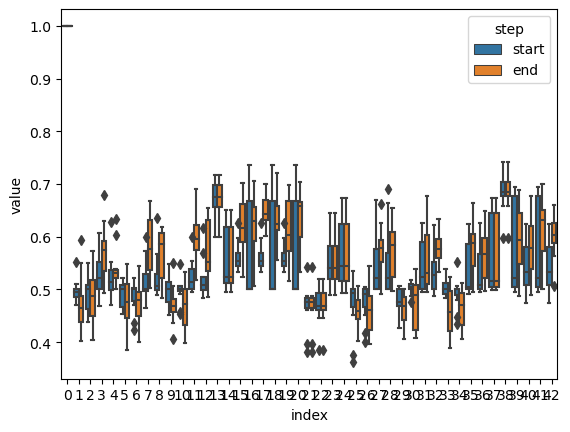

In [485]:
plot_expert_runs_al(metrics, 4295232296, "Val", "accurancy_balanced")

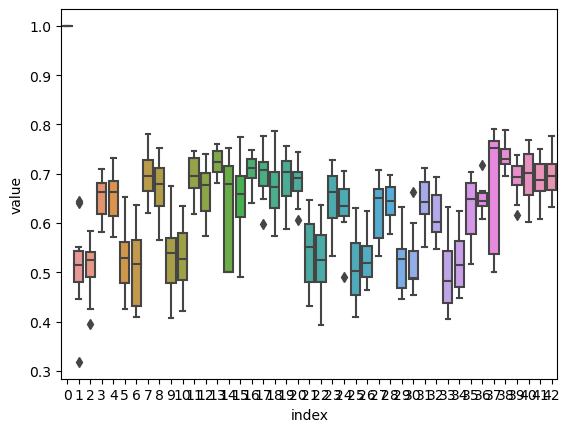

In [486]:
plot_expert_runs_end(metrics, 4323195249, "Val", "accurancy_balanced")

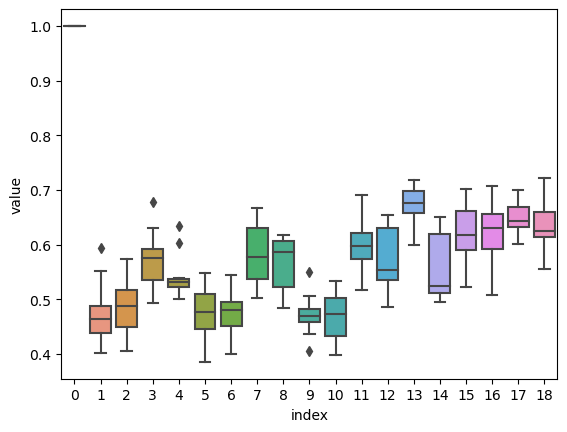

In [987]:
plot_expert_runs_end(metrics, 4295232296, "Val", "accurancy_balanced")

In [503]:
temp = pd.DataFrame(metrics[4323195249]).reset_index().melt('index', var_name='step',  value_name='vals')
temp["vals"]

0     {'Seed_1_Fold_0': 0.5714285714285714, 'Seed_1_...
1     {'Seed_1_Fold_0': 0.48376623376623373, 'Seed_1...
2     {'Seed_1_Fold_0': 0.5383141762452107, 'Seed_1_...
3     {'Seed_1_Fold_0': 0.5523627075351213, 'Seed_1_...
4     {'Seed_1_Fold_0': 0.5422077922077922, 'Seed_1_...
5     {'Seed_1_Fold_0': 0.5064935064935064, 'Seed_1_...
6     {'Seed_1_Fold_0': 0.5346956151553852, 'Seed_1_...
7     {'Seed_1_Fold_0': 0.5162337662337663, 'Seed_1_...
8     {'Seed_1_Fold_0': 0.4253246753246753, 'Seed_1_...
9     {'Seed_1_Fold_0': 0.6215410813111962, 'Seed_1_...
10    {'Seed_1_Fold_0': 0.6700723712217964, 'Seed_1_...
11    {'Seed_1_Fold_0': 0.6331168831168831, 'Seed_1_...
12    {'Seed_1_Fold_0': 0.6233766233766234, 'Seed_1_...
13    {'Seed_1_Fold_0': 0.6875266070668369, 'Seed_1_...
Name: vals, dtype: object

In [ ]:
.melt(var_name='Expert', value_name='values')